In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import csv
from collections import Counter

## Reading in the User Reviews

Var `users` is just a count of the reviews written by an individual user.


For now, I am saving only the `reviewer`, `game`, `id`, and `score` in `reviews` list

In [22]:
users = Counter()
reviews = []
for i in range(0,26900, 100):
    with open(f'./review_data/reviews_list_{i}.json', 'r') as f:
        file = json.load(f)
#         reviews.extend([for review in file]) # TODO implement this part.  Forgot to scrape the actual games that the review is for
    users.update([review['reviewer'] for review in file])


In [21]:
reviews

[{'deck': 'Review Monster',
  'description': "Hey, I bet this gives no tangible notice that I've completed this review. Sean thinks that people will anally fill out multiple reviews of multiple platforms all in one sitting. If they did, do you know what they'd fill out? The SAME review COPY/PASTED into the exact same review box for a separate platform.",
  'guid': '2200-5',
  'reviewer': 'snide',
  'score': 5,
  'site_detail_url': 'https://www.giantbomb.com/pac-man/3030-7624/user-reviews/2200-5/'},
 {'deck': 'My Favorite Combat RPG of All Time',
  'description': 'Rambling on about one of my favorite games. Nerd alert.It\'s funny you know, I have this amazing gaming PC at home (my work machine on the other hand is a Mac) and despite it being able to put my xbox 360 to shame I find myself regularly loading up a 2D based RPG released almost 4 years ago by a legendary, though now defunct studio. What has me playing Icewind Dale 2 instead of Oblivion (which is a great game that I still have

### Get number of users who have written at least `review_thresh` reviews

In [15]:
review_thresh = 4
review_stars = [user[0] for user in users.most_common() if user[1]>=review_thresh]
len(review_stars)

1512

# Game Meta Data EDA

In [9]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./game_meta_data/') if isfile(join('./game_meta_data/', f))]

In [42]:
list_of_meta = []
for file in onlyfiles:
    with open(f'./game_meta_data/{file}', 'r') as f:
        game = json.load(f)
        feature_list = ['guid', 'name', 'concepts', 'themes', 'deck', 'developers', 'publishers', 'genres']
        game_dict = {key:value for key, value in game.items() if key in feature_list}

        # convert lists to strings 
        for key, value in game_dict.items():
            if type(value) == list:
                game_dict[key] = ', '.join(value)
        list_of_meta.append(game_dict)
df = pd.DataFrame(list_of_meta)

In [43]:
df.head()

,concepts,deck,developers,genres,guid,name,themes
0,"Achievements, PlayStation Trophies, Steam, Dig...",Kill The Bad Guy is a puzzle-game where physic...,Exkee,"Strategy, Simulation",3030-46539,Kill the Bad Guy,None
1,None,Zeal is an indie online ARPG developed by Lyca...,Lycanic Studios,"Action, Role-Playing, MOBA",3030-68714,Zeal,"Fantasy, Medieval"
2,None,Vertical Drop Heroes HD is an action platformer.,Nerdook Productions,"Action, Role-Playing, Platformer",3030-48249,Vertical Drop Heroes HD,Fantasy
3,"Unreal Engine 4, PlayStation VR Support",A puzzle mystery game for PS VR.,Tarsier Studios,Puzzle,3030-57976,Statik,None
4,None,A compilation of all three Banner Saga titles.,Stoic,"Strategy, Role-Playing, Compilation",3030-68731,The Banner Saga Trilogy,Fantasy


### Using `concepts` to test initial EDA and to use as features for a content filter prototype

This should eventually be generalized as a function that takes in any column or one that just does all the right cols

In [44]:
df.concepts = ['' if concept == None else concept for concept in df.concepts ]

In [45]:
df['num_concepts'] = list(map(lambda x: len(x.split(',')), df.concepts))

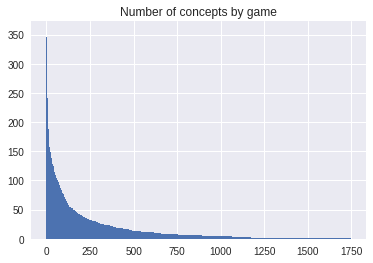

In [46]:
x = [i for i in range(df.shape[0])]
plt.bar(x, height=df.sort_values(by='num_concepts', ascending=False).num_concepts, width=1)
plt.title('Number of concepts by game')

In [47]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate a CountVectorizer
cvec = CountVectorizer(stop_words='english', tokenizer=lambda x: x.split(', '))
bow = cvec.fit_transform(df.concepts)


In [48]:
contents_df  = pd.DataFrame(bow.todense(),
                   columns=cvec.get_feature_names())
contents_df.head()

,,180 degree turn,2.5d,21:9 ultrawide support,21st annual d.i.c.e. awards,285 code 6,2d,2d depth attack,3 round burst,360 flip,...,zombie pigmen,zombie protagonist,zombie virus,zombrex,zoning character,zoom,zoom platform,zooming out to orbit,zooming to platform pathway,zu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
df.shape

(1746, 8)

## lets drop all the features that apply to less than 5 games

In [50]:
contents_df.shape

(1746, 3766)

In [51]:
thresh = 5
cols_to_drop = []
for col in contents_df.columns:
    try:
        if contents_df[col].value_counts()[0] >=contents_df.shape[0]-thresh:
            cols_to_drop.append(col)
    except: 
        print(col)


In [52]:
len(cols_to_drop)

2579

In [53]:
contents_df.drop(cols_to_drop, axis=1, inplace=True)
contents_df.shape

(1746, 1187)

## Doing the same, but with the actual games

In [54]:
rows_to_drop = []
for ind in contents_df.T.columns:
    if contents_df.T.get(ind).sum() < thresh:
        rows_to_drop.append(ind)

In [55]:
len(rows_to_drop)

816

In [56]:
contents_df.drop(rows_to_drop, axis = 0, inplace=True)
contents_df.shape

(930, 1187)

In [72]:
merged = pd.merge(df, contents_df, left_index=True, right_index=True, )

In [73]:
merged.shape

(930, 1195)

In [74]:
merged.head()

,concepts,deck,developers,genres,guid,name,themes,num_concepts,,180 degree turn,...,xbox one backwards compatibility,xbox one controller support for pc,xbox one x enhanced,xbox play anywhere,xfire,year in the title,young protagonist,zombie,zoning character,zoom
0,"Achievements, PlayStation Trophies, Steam, Dig...",Kill The Bad Guy is a puzzle-game where physic...,Exkee,"Strategy, Simulation",3030-46539,Kill the Bad Guy,None,11,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"Double Jump, Teleportation, Achievements, Boss...",The third entry in the Super Mario Bros inspir...,Black Forest Games,Platformer,3030-39484,Giana Sisters: Twisted Dreams,Fantasy,78,0,0,...,0,0,0,0,0,0,0,0,0,0
11,"Ninja, Anthropomorphism, Crossover, Sexualized...",A crossover Warriors game from Omega Force and...,Omega Force,Action,3030-55468,Warriors All-Stars,"Fantasy, Alternate Historical",8,0,0,...,0,0,0,0,0,0,0,0,0,0
12,"Steam, Digital Distribution, Indie, PlayStatio...",We Are Doomed is a frantic shoot-em-up in a vi...,Vertex Pop,Shoot 'Em Up,3030-45908,We Are Doomed,None,7,0,0,...,0,0,0,0,0,0,0,0,0,0
14,"Combo, Achievements, Health, Heads Up Display,...",The third major installment of the Street Figh...,"Dimps Corporation, Capcom",Fighting,3030-43241,Ultra Street Fighter IV,Martial Arts,92,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
merged.set_index(['name'], inplace=True)

In [76]:
merged.drop(['concepts', 'deck', 'developers', 'genres', 'themes', 'num_concepts', '', 'guid'], 1, inplace=True)

In [77]:
merged.shape

(930, 1186)

In [78]:
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances

In [79]:
sparse_content = sparse.csr_matrix(merged)

In [80]:
distances = pairwise_distances(sparse_content, metric='cosine')

In [81]:
distance_df = pd.DataFrame(distances, index=merged.index, columns=merged.index)
distance_df.head()

name,Kill the Bad Guy,Giana Sisters: Twisted Dreams,Warriors All-Stars,We Are Doomed,Ultra Street Fighter IV,Arcania: Gothic 4,Lichdom: Battlemage,The King of Fighters Collection: The Orochi Saga,Alien Shooter,JumpJet Rex,...,LEGO Marvel Super Heroes 2,Sword Art Online: Hollow Fragment,Alienation,World Heroes 2 JET,Mystereet F: Tantei-tachi no Curtain Call,Hotline Miami 2: Wrong Number,The Magic Circle,Gran Turismo Sport,Mighty No. 9,Sonic Forces
name,,,,,,,,,,,,,,,,,,,,,
Kill the Bad Guy,0.000000,0.736178,1.000000,0.772079,0.709618,0.875753,0.654143,0.922150,0.899496,0.844300,...,1.000000,0.865160,0.932580,1.000000,1.000000,0.944011,0.912961,1.0,0.729235,1.000000
Giana Sisters: Twisted Dreams,0.736178,0.000000,1.000000,0.858263,0.819421,0.879810,0.827938,0.967725,0.916667,0.838626,...,0.966592,0.944098,0.888197,1.000000,1.000000,0.907152,0.963916,1.0,0.708141,0.903175
Warriors All-Stars,1.000000,1.000000,0.000000,1.000000,0.954498,1.000000,1.000000,0.902410,1.000000,1.000000,...,0.898985,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
We Are Doomed,0.772079,0.858263,1.000000,0.000000,0.863495,0.896165,0.653156,0.902410,0.874012,0.902410,...,1.000000,0.830969,0.830969,1.000000,1.000000,0.789441,0.672673,1.0,0.796347,1.000000
Ultra Street Fighter IV,0.709618,0.819421,0.954498,0.863495,0.000000,0.884246,0.723816,0.875666,0.959871,0.875666,...,0.967826,0.946162,0.919243,0.833055,0.950853,0.932935,0.895743,1.0,0.827024,1.000000


In [84]:
search = 'Uncharted'
for title in df.loc[df['name'].str.contains(search), 'name'].values:
    print(title)
#     print('Average rating:', merged[merged['name'] == title].mean())
#     print('Number of ratings:', merged[merged['name'] == title].count())
#     print()
    print('Similar Games:')
    print(distance_df[title].sort_values()[1:11])
    print()
    print()
    

Uncharted: The Nathan Drake Collection
Similar Games:
name
Rez Infinite                                     0.664590
Salt and Sanctuary                               0.683772
Uncharted 4: A Thief's End                       0.693030
Death's Gambit                                   0.700000
FutureGrind                                      0.717157
Thumper                                          0.726139
Guacamelee!: Super Turbo Championship Edition    0.726139
Guns Up!                                         0.741801
Skytorn                                          0.741801
Dungeon Defenders II                             0.760954
Name: Uncharted: The Nathan Drake Collection, dtype: float64


Uncharted 4: A Thief's End
Similar Games:
name
Uncharted: The Nathan Drake Collection    0.693030
Rise of the Tomb Raider                   0.695224
The Last of Us                            0.725489
Hitman                                    0.730931
Star Wars Battlefront                     0.742